# Data Wrangling Template

## Load all libraries

In [713]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import os
import requests
import string
import tweepy
import time
from ipywidgets import FloatProgress
from IPython.display import display
from bs4 import BeautifulSoup
%matplotlib inline


## Key Points

* You only want `original ratings` (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least `8 quality issues` and at least `2 tidiness issues` in this dataset.
* Cleaning includes merging individual pieces of data according to the rules of tidy data.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond `August 1st, 2017`. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.
* https://review.udacity.com/#!/rubrics/1136/view
* submission:
    * `wrangle_act.ipynb`: code for gathering, assessing, cleaning, analyzing, and visualizing data
        * `wrangle_report.pdf` or wrangle_report.html: documentation for data wrangling steps: gather, assess, and clean
    * `act_report.pdf` or act_report.html: documentation of analysis and insights into final data
    * `twitter_archive_enhanced.csv`: file as given
    * `image_predictions.tsv`: file downloaded programmatically
    * `tweet_json.txt`: file constructed via API
    * `twitter_archive_master.csv`: combined and cleaned data
    * any additional files (e.g. files for additional pieces of gathered data or a database file for your stored clean data)

## Data Source

* `twitter_archive_enhanced.csv` --> download locally 
* `image_predictions.tsv`--> downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv 
* `tweet_json.txt` -->  query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with **(at minimum) tweet ID, retweet count, and favorite count**. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.
  

## Test Twitter

In [714]:
# read the secrets 
access_data = pd.read_csv('tweety_auth.csv')

In [715]:
#
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [716]:
consumer_key = access_data.consumer_key.iloc[0]
consumer_secret = access_data.consumer_secret.iloc[0]
access_token = access_data.access_token.iloc[0]
access_secret = access_data.access_secret.iloc[0]
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [717]:
test = api.get_status(twitter_archive.tweet_id.iloc[0], tweet_mode='extended')

In [718]:
print('Test is sucessful, returned ID: {}'.format(test.id))

Test is sucessful, returned ID: 892420643555336193


## Gather

1st step of the process, I'll need to gather the following sources:

1.  `twitter_archive_enhanced.csv`: downloaded locally 
2.  `image_predictions.tsv`: downloaded programmatically using the Requests library and the following [URL]( https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv) 
3. `tweet_json.txt`: query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with **(at minimum) tweet ID, retweet count, and favorite count**. 

### 1.  `twitter_archive_enhanced.csv`



In [719]:
# once again
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [720]:
# one quick look
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### 2.  `image_predictions.tsv`

In [721]:
# Gather the data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# create response object
response = requests.get(url)

In [722]:
# Create file from the response object
# split @ / and return the last instance
file_name  = url.split('/')[-1]
with open(os.path.join(file_name), mode='wb') as file:
    file.write(response.content)

In [723]:
# read the jsut created tsv file, important set the sep to '\t'
image_predictions = pd.read_csv(file_name, sep='\t')

In [724]:
# one quick look 
image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


### 3. `tweet_json.txt`


In [725]:
# I saved my secrets in a file which is ignored by githib 
access_data = pd.read_csv('tweety_auth.csv')

In [726]:
# access keys and tokens
consumer_key = access_data.consumer_key.iloc[0]
consumer_secret = access_data.consumer_secret.iloc[0]
access_token = access_data.access_token.iloc[0]
access_secret = access_data.access_secret.iloc[0]
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
# create a API object which waits when the twitter limit is reached and also send a notification 
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [727]:
# test to figure out how we can access and populate the needed attributes 
single_tweet = api.get_status(twitter_archive.tweet_id.iloc[0], tweet_mode='extended')
# Tweet ID 
print('Tweet ID: {}'.format(single_tweet.id_str))
# Retweet count 
print('Retweet Count: {}'.format(single_tweet.retweet_count))
# Favourite Count
print('Favourite Count: {}'.format(single_tweet.favorite_count))

Tweet ID: 892420643555336193
Retweet Count: 8188
Favourite Count: 37534


In [728]:
# Make file if it doesn't already exist
file_name = 'tweet_json.txt'
if not os.path.isfile(file_name):
    open(file_name, 'w').close()

In [729]:
# https://jgardiner.co.uk/blog/jupyter_progress_bar
# https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py
# https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
tweets = twitter_archive.tweet_id
max_bar = len(tweets)
f = FloatProgress(min=0, max=max_bar)
display(f)
# measure the time 
start_time = time.time()
# collect teh errors with code
tweet_errors = {}
#collect the success tweets
tweet_succsess = []
# collect the data
data = []

# open a file for write access
with open(file_name, 'w', encoding='utf-8') as file:
    # each tweet shall be in one line 
    for tweet_id in tweets:
            try:
        #       Progress bar
                f.value += 1

                # Collect tweet info
                single_tweet = api.get_status(tweet_id, tweet_mode='extended')
                content = single_tweet._json

                # Append to file
                json.dump(content, file)
                # end of line --> next line = start of new tweet
                file.write('\n')
                # Append to success list
                tweet_succsess.append(tweet_id)
            # exception handling for e.g. missing tweets
            except Exception as e:
                # Print exception info and add to tweet_errors dict
                print(str(tweet_id) + ": " + str(e))
                tweet_errors[str(tweet_id)] = str(e)
        
print("This took %s seconds." % (time.time() - start_time))

FloatProgress(value=0.0, max=2356.0)

888202515573088257: [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921: [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937: [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745: [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329: [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744: [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320: [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130: [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705: [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984: [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648: [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308: [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977: [{'code': 144, 'mess

Rate limit reached. Sleeping for: 686


754011816964026368: [{'code': 144, 'message': 'No status found with that ID.'}]
680055455951884288: [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 684


This took 2032.0132148265839 seconds.


In [730]:
# Quickly check if we got all of them
len(tweet_succsess) + len(tweet_errors) == len(twitter_archive.tweet_id)

True

In [731]:
len(tweet_errors)

19

In [732]:
# https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/

# read the file line by line 
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
i= 1
with open('tweet_json.txt', 'r') as json_file:
    #each line (remember one line represents a tweet)
    for line in json_file:
        # transform to json
        json_line = json.loads(line)
        #Append to list of dictionaries
        df_list.append({'tweet_id': json_line['id'],
                        'retweet_count': json_line['retweet_count'],
                        'favorite_count': json_line['favorite_count']})
    
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html#pandas.DataFrame                       
# Create the respectibe pandas DataFrame with tweet ID, retweet count, favorite count
twitter_api = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [733]:
twitter_api.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8188,37534


## Assess

### Get an overview

In [734]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [735]:
twitter_archive.count()

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2356
source                        2356
text                          2356
retweeted_status_id            181
retweeted_status_user_id       181
retweeted_status_timestamp     181
expanded_urls                 2297
rating_numerator              2356
rating_denominator            2356
name                          2356
doggo                         2356
floofer                       2356
pupper                        2356
puppo                         2356
dtype: int64

In [736]:
# check for retweets
twitter_archive[twitter_archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [737]:
twitter_archive[twitter_archive.retweeted_status_id.notnull()]['tweet_id'].count()

181

In [738]:
twitter_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8188,37534
1,892177421306343426,6057,32261
2,891815181378084864,4008,24307
3,891689557279858688,8339,40874
4,891327558926688256,9033,39068


In [739]:
twitter_api.count()

tweet_id          2337
retweet_count     2337
favorite_count    2337
dtype: int64

In [740]:
twitter_api.query('tweet_id == "885311592912609280"')

,tweet_id,retweet_count,favorite_count
35,885311592912609280,17885,0


In [741]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [742]:
image_predictions.count()

tweet_id    2075
jpg_url     2075
img_num     2075
p1          2075
p1_conf     2075
p1_dog      2075
p2          2075
p2_conf     2075
p2_dog      2075
p3          2075
p3_conf     2075
p3_dog      2075
dtype: int64

In [743]:
image_predictions.query('tweet_id == "885311592912609280"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


`Information Gain`
* data source structures (listed below for furher analysis)
* the 3 data sources have different number of records --> needs to be checked 
* data seems to be in 1:1 relationship to each other, hence the data frames can be joined (<font color='red'>**add to tidiness**</font>)
* doggo, floofer, pupper and puppo are dog stages and can merged into a categorial field (<font color='red'>**add to tidiness**</font>)
* in the project description it is mentioned that only original tweets are relevant, so we need to take care on those "duplicates". Technally each etweet hets a new id referencing to the original one. (<font color='red'>**add to quality**</font>)
* the twitter api access was returning 19 times "No status found with that ID.". Assumption those tweets haev being purged.  (<font color='red'>**add to quality**</font>)


### Sources and their structures
Let's check if we find typos or similar

#### `twitter_archive`:

* `tweet_id`: the unique identifier of tweets
* `in_reply_to_status_id`: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
* `in_reply_to_user_id`: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
* `timestamp`: timestamp creation of the Tweet
* `source`: device from where the Tweet was posted, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
* `text`: actual text of the status update
* `retweeted_status_id`: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
* `retweeted_status_user_id`: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
* `retweeted_status_timestamp`: timestamp of retweet
* `expanded_urls`: tweet URL
* `rating_numerator`: numerator of the rating of a dog 
* `rating_denominator`: denominator of the rating of a dog
* `name`: name of the dog
* `doggo`: respective dog stage
* `floofer`: respective dog stage
* `pupper`: respective dog stage
* `puppo`: respective dog stage


#### `image_predictions`

* `tweet_id`: the unique identifier of tweet
* `jpg_url`: dog's image URL
* `img_num`: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
* `p1`: algorithm's #1 prediction for the image in the tweet
* `p1_conf`: how confident the algorithm is in its #1 prediction
* `p1_dog`: whether or not the #1 prediction is a breed of dog
* `p2`: algorithm's #2 prediction for the image in the tweet
* `p2_conf`: how confident the algorithm is in its #2 prediction
* `p2_dog`:	 whether or not the #2 prediction is a breed of dog
* `p3`: algorithm's #3 prediction for the image in the tweet
* `p3_conf`: how confident the algorithm is in its #3 prediction
* `p3_dog`: whether or not the #3 prediction is a breed of dog!

#### `twitter_api`
* `tweet_id`: the unique identifier of tweets
* `retweet_count`: number of times this Tweet has been retweeted
* `favorite_count`: indicates approximately how many times this Tweet has been liked by Twitter users!

### The threee data sources have different number of records

In [744]:
len(tweet_errors)

19

In [745]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [746]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
tweet_id          2337 non-null int64
retweet_count     2337 non-null int64
favorite_count    2337 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [747]:
len(twitter_archive.tweet_id) - len(tweet_errors)

2337

In [748]:
# the number seems to match let's make a check and filter the archive with all available api_ids 
# the data types are equal
twitter_archive[twitter_archive['tweet_id'].isin(twitter_api.tweet_id)]['tweet_id'].count()

2337

In [749]:
# looks good

In [750]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [751]:
# let's check for twitter api to images
image_predictions[image_predictions['tweet_id'].isin(twitter_api.tweet_id)]['tweet_id'].count()

2065

`Information Gain`
* although the number of records from archive to api data frame seems to match (after taking the 19 deleted tweetsinto account, the number of image_predictions isn't matching  (<font color='red'>**add to quality**</font>)

### Examine  `twitter_archive`

In [752]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [753]:
# drop the columns
# retweeted_status_id           
# retweeted_status_user_id      
# retweeted_status_timestamp    

In [754]:
# timestamp wrong dataytpe 

In [755]:
# let's examine source 
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [756]:
# wow most of those tweets are originated from an iphone ---> this will be a hypothetis are Iphone Users dog lovers
# However those can be cleaned the surrounding html can be dropped so that we have e.g. "Twitter for iPhone" left.

In [757]:
twitter_archive.text.duplicated().sum()

0

In [758]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
Daisy          7
Buddy          7
an             7
Bailey         7
Toby           7
Leo            6
Dave           6
Bella          6
Milo           6
Jax            6
Rusty          6
Oscar          6
Jack           6
Koda           6
Stanley        6
Scout          6
Sunny          5
            ... 
Eugene         1
Tango          1
Carper         1
Remy           1
old            1
Lilli          1
Jersey         1
Tyrus          1
Georgie        1
Franq          1
Nida           1
Rey            1
Pherb          1
Tino           1
Brandi         1
Charleson      1
Linus          1
Dobby          1
Vixen          1
Arya           1
Jebberson      1
Rufio          1
Banjo          1
Willie         1
Adele          1
Noosh          1
Ralf           1
Bobb          

In [759]:
len(twitter_archive[twitter_archive['name'].str.len() < 4]['name'].value_counts().index.tolist())

68

In [760]:
twitter_archive[twitter_archive['name'].str.len() < 4]['name'].value_counts().index.tolist()

['a',
 'Bo',
 'the',
 'an',
 'Jax',
 'Leo',
 'Gus',
 'one',
 'Mia',
 'Ted',
 'Max',
 'Bob',
 'Sam',
 'Moe',
 'Ava',
 'Doc',
 'not',
 'mad',
 'Tyr',
 'Eve',
 'Eli',
 'Ken',
 'Lou',
 'Ash',
 'Dot',
 'Al',
 'Ace',
 'Taz',
 'Jim',
 'Evy',
 'Jed',
 'Sky',
 'JD',
 'Mo',
 'my',
 'his',
 'Ike',
 'Obi',
 'Jo',
 'Amy',
 'Edd',
 'all',
 'Ben',
 'Stu',
 'Zoe',
 'Dug',
 'Ito',
 'Tug',
 'Aja',
 'Rey',
 'by',
 'old',
 'Ed',
 'Jay',
 'Gin',
 'Sid',
 'Mya',
 'O',
 'Ron',
 'Tom',
 'Mac',
 'Ole',
 'Pip',
 'Cal',
 'Dex',
 'Jeb',
 'Alf',
 'Blu']

In [761]:
# we can replace some of those 68 with NaN as they are not existent (e.g "a",....) precise selection will be done
# while cleaning

In [762]:
# finally Tweet ID is integer can be converted to string

`Information Gain`
* after purging the retweets the 3 columns retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not necessary any longer and can be dropped. (<font color='red'>**add to quality**</font>) 
* timestamp wrong dataype (string insead of datetype) (<font color='red'>**add to quality**</font>) 
* source surrounding html can be dropped so that we have e.g. "Twitter for iPhone" left. (<font color='red'>**add to quality**</font>)
- **name** we can replace some of those 68 with NaN as they are not existent (e.g "a",....) precise selection will be done while cleaning (<font color='red'>**add to quality**</font>)
- **Tweet ID** is integer can be converted to string, (<font color='red'>**add to quality**</font>)

### Examine  `twitter_api`

In [763]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
tweet_id          2337 non-null int64
retweet_count     2337 non-null int64
favorite_count    2337 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [764]:
twitter_api.sample(10)

,tweet_id,retweet_count,favorite_count
1391,699060279947165696,1898,3899
2023,671538301157904385,400,929
1388,699088579889332224,662,2317
249,843235543001513987,6332,22153
309,834209720923721728,5063,21368
1426,696713835009417216,678,2456
954,750086836815486976,570,2266
474,814153002265309185,9355,30311
935,751830394383790080,2068,6032
2295,666701168228331520,215,424


In [765]:
twitter_api.describe()

,tweet_id,retweet_count,favorite_count
count,2.337000e+03,2337.000000,2337.000000
mean,7.420692e+17,2876.921267,7842.008130
std,6.824243e+16,4860.035367,12154.540731
min,6.660209e+17,1.000000,0.000000
25%,6.783345e+17,580.000000,1363.000000
50%,7.185406e+17,1344.000000,3421.000000
75%,7.986825e+17,3356.000000,9607.000000
max,8.924206e+17,82434.000000,162084.000000


In [766]:
twitter_api.head(3)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8188,37534
1,892177421306343426,6057,32261
2,891815181378084864,4008,24307


In [767]:
twitter_api.sort_values('retweet_count',ascending=False, inplace=True)
twitter_api.head(10)

,tweet_id,retweet_count,favorite_count
1021,744234799360020481,82434,162084
1061,739238157791694849,61045,119841
520,807106840509214720,60130,125285
400,822872901745569793,46997,138417
65,879415818425184262,42844,102777
436,819004803107983360,39557,91095
433,819015337530290176,39557,0
523,806629075125202948,37613,79208
129,866450705531457537,34949,120424
1747,678399652199309312,33249,81367


In [768]:
twitter_api.sort_values('favorite_count',ascending=False, inplace=True)
twitter_api.head(10)

,tweet_id,retweet_count,favorite_count
1021,744234799360020481,82434,162084
400,822872901745569793,46997,138417
520,807106840509214720,60130,125285
129,866450705531457537,34949,120424
1061,739238157791694849,61045,119841
65,879415818425184262,42844,102777
436,819004803107983360,39557,91095
162,859196978902773760,30327,89554
1747,678399652199309312,33249,81367
111,870374049280663552,25738,80996


`Information Gain`
* **tweet_id** is integer can be converted to string, (<font color='red'>**add to quality**</font>)

### Examine  `image_predictions`

In [769]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [770]:
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [771]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1044,712717840512598017,https://pbs.twimg.com/media/CeQVF1eVIAAJaTv.jpg,1,Great_Pyrenees,0.732043,True,kuvasz,0.121375,True,Irish_wolfhound,0.049524,True
1430,773191612633579521,https://pbs.twimg.com/media/CrrtqjdXEAINleR.jpg,1,Blenheim_spaniel,0.427766,True,Shih-Tzu,0.219256,True,Welsh_springer_spaniel,0.144614,True
1095,720043174954147842,https://pbs.twimg.com/media/Cf4bcm8XEAAX4xV.jpg,1,Samoyed,0.954517,True,Eskimo_dog,0.029130,True,white_wolf,0.004462,False
1742,822647212903690241,https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg,1,Samoyed,0.416769,True,malamute,0.252706,True,kuvasz,0.157028,True
1207,742161199639494656,https://pbs.twimg.com/media/CkyvqnNWYAQxQY1.jpg,1,balloon,0.990736,False,punching_bag,0.004754,False,parachute,0.000436,False
790,690649993829576704,https://pbs.twimg.com/media/CZWugJsWYAIzVzJ.jpg,1,bighorn,0.215438,False,hyena,0.137928,False,Mexican_hairless,0.098171,True
439,674436901579923456,https://pbs.twimg.com/media/CVwUyM9WwAAGDjv.jpg,1,acorn_squash,0.375392,False,Shih-Tzu,0.105416,True,Lhasa,0.072832,True
1483,781251288990355457,https://pbs.twimg.com/media/CteP5H5WcAEhdLO.jpg,2,Mexican_hairless,0.887771,True,Italian_greyhound,0.030666,True,seat_belt,0.026730,False
1116,725729321944506368,https://pbs.twimg.com/media/ChJO9YaWYAEL0zC.jpg,1,boxer,0.599076,True,bull_mastiff,0.177318,True,French_bulldog,0.141461,True
1734,821522889702862852,https://pbs.twimg.com/media/C2aitIUXAAAG-Wi.jpg,1,Doberman,0.763539,True,black-and-tan_coonhound,0.136602,True,miniature_pinscher,0.087654,True


In [772]:
image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
web_site                      19
Cardigan                      19
Eskimo_dog                    18
teddy                         18
Maltese_dog                   18
beagle                        18
Shetland_sheepdog             18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [773]:
# I think we need to extract the breed data into own field at least the fields p2-p3 can be dropped. 
# In teh breed foeld we should capitalize first letter.

In [774]:
# finally tweet_id is integer can be converted to string

`Information Gain`
* new breed field --> get the p1 prediction into a separate field and capitalize teh first letter (<font color='red'>**add to quality**</font>) 
* get rid of p1 and p2 fields. (<font color='red'>**add to tidiness**</font>)
* **tweet_id** is integer can be converted to string, (<font color='red'>**add to quality**</font>)


### Quality Issues
<div class="alert alert-block alert-danger">
    
##### `twitter_archive` data frame
- `No Retweeets`: In the project description it is mentioned that only original tweets are relevant, so we need to take care on those "duplicates". Technally each tweet gets a new id referencing to the original one.
- `API errors`: the twitter api access was returning 19 times "No status found with that ID.". Assumption those tweets have being purged.
- `Image predictions aren't matching twitter archive`: the number of image_predictions and (twitter_archive-**19 deleted**) isn't matching.
- `Unecessary Colums`: after purging the retweets the 3 columns retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not necessary any longer and can be dropped.
- `Timestamp data type`: timestamp wrong dataype (string insead of datetype)
- `Reduce to source`: **source** surrounding html can be dropped so that we have e.g. "Twitter for iPhone" left.
- `Name column cleaning`: **name** we can replace some of those 68 with NaN as they are not existent (e.g "a",....) precise selection will be done while cleaning
- `Tweet ID data type `: **tweet_id** is integer can be converted to string


##### `twitter_api` data frame

- `Tweet ID data type`: **tweet_id** is integer can be converted to string

##### `image_predictions` data frame
- `new breed field`: new breed field --> get the p1 prediction into a separate field and capitalize teh first letter 
- `Tweet ID data type`: **tweet_id** is integer can be converted to string
- `get rid of p1 and p2`: uncesssary fields the 2nd and 3rd results of predictions can be dropped
</div>

### Tidiness Issues
<div class="alert alert-block alert-danger">
    
    
#### `common across all three tables`

- `Merger`: **all data frames** seems to be in 1:1 relationship to each other, hence tehy can be merged


#### `twitter_archive` data frame
- `Fragmented Field `: doggo, floofer, pupper and puppo are dog stages and can merged into a categorial field

#### `twitter_api` data frame
- no issues detected


#### `image_predictions` data frame
- no issues detected



</div>

## Clean

We will go for the approach to first clean missing and inconsistent data, then we will taggle the tidiness issues and finally the remaining quality issues.

In [775]:
# make copies of the original datasets
twitter_archive_clean = twitter_archive.copy()
twitter_api_clean = twitter_api.copy()
image_predictions_clean = image_predictions.copy()

### Quality Issues - Missing data / Inconsistent Data
<div class="alert alert-block alert-info">
    
#### `twitter_archive` data frame
- `No Retweeets`: In the project description it is mentioned that only original tweets are relevant, so we need to take care on those "duplicates". Technally each tweet gets a new id referencing to the original one.
- `API errors`: the twitter api access was returning 19 times "No status found with that ID.". Assumption those tweets have being purged.
- `Image predictions aren't matching twitter archive`: the number of image_predictions and (twitter_archive-**19 deleted**) isn't matching.

</div>

### `twitter_archive` data frame

#### Define `No Retweets`:
In the project description it is mentioned that only original tweets are relevant, so we need to take care on those "duplicates". Technally each tweet gets a new id referencing to the original one. We only need to keep all records where the `retweeted_status_id` is  null, the rest can be purged. 

#### Code

In [776]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

#### Test

In [777]:
twitter_archive_clean['retweeted_status_id'].notnull().sum()

0

#### Define `API errors`:
The twitter api access was returning 19 times "No status found with that ID.". Assumption those tweets have being purged. Let's take the dictionary of the errors produced during the API call and delete those records

#### Code

In [778]:
# derived during gathering
tweet_errors

{'888202515573088257': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '873697596434513921': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '872668790621863937': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '872261713294495745': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '869988702071779329': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '866816280283807744': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '861769973181624320': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '856602993587888130': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '845459076796616705': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '844704788403113984': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '842892208864923648': "[{'code': 144, 'message': 'No status found with that ID.'}]",
 '837012587749474308': "[{'code': 144, 'message': 'No 

In [779]:
twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(tweet_errors.keys())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872261713...,13,10,Harry,None,None,None,None
253,844704788403113984,NaN,NaN,2017-03-23 00:18:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,None,None,None,None
932,754011816964026368,NaN,NaN,2016-07-15 17:56:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He pouts until he gets to go ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754011816...,12,10,Charlie,None,None,None,None
1726,680055455951884288,NaN,NaN,2015-12-24 16:00:30 +0000,"<a href=""https://about.twitter.com/products/tw...","Meet Sammy. At first I was like ""that's a snow...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None


In [780]:
# ok I believe the purge before of the retweets already helped here as only 4 of the 19 errors are left. Let's get rid
# of the remaining ~ negates the isin 
# https://stackoverflow.com/questions/19960077/how-to-implement-in-and-not-in-for-pandas-dataframe
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(tweet_errors.keys())]

#### Test

In [781]:
twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(tweet_errors.keys())]['tweet_id'].count()

0

#### Define `Image predictions aren't matching twitter archive`:
The number of image_predictions and (twitter_archive-**19 deleted**) isn't matching. We need to reduce further. we need to keep the tweets which are in equl in both data frames image_predictions_clean and twitter_archive_clean.

#### Code

In [782]:
twitter_archive_clean = \
 twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(image_predictions_clean['tweet_id'])]

#### Test

In [783]:
twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(image_predictions_clean['tweet_id'])]['tweet_id'].sum()

0

### Tidiness Issues
<div class="alert alert-block alert-info">
    

#### `common across all three tables`

- `Merger`: **all data frames** seems to be in 1:1 relationship to each other, hence tehy can be merged


#### `twitter_archive` data frame
- `Fragmented Field `: doggo, floofer, pupper and puppo are dog stages and can merged into a categorial field



</div>

### `common across all three tables`

#### Define ` Merger`:

**All data frames** (twitter_archive_clean, twitter_api_clean) and image_predictions_clean are in 1:1 relationship to each other, hence they can be merged. We will take twitter_archive_clean as left, then twitter_api_clean and then image_predictions_clean (`default as **inner**`). The number of records will align to the number of records in in each intersection.

#### Code

In [784]:
image_predictions_clean.tweet_id.count()

2075

In [785]:
twitter_api_clean.tweet_id.count()

2337

In [786]:
twitter_archive_clean.tweet_id.count()

1990

In [787]:
# through left join we will merge the data  
# https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
twitter_master = \
    twitter_archive_clean.merge(twitter_api_clean, on='tweet_id').merge(image_predictions_clean,on='tweet_id')

In [788]:
twitter_master2 = \
    twitter_archive_clean.merge(twitter_api_clean, on='tweet_id')

In [789]:
twitter_master2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 19 columns):
tweet_id                      1990 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1990 non-null object
source                        1990 non-null object
text                          1990 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1990 non-null object
rating_numerator              1990 non-null int64
rating_denominator            1990 non-null int64
name                          1990 non-null object
doggo                         1990 non-null object
floofer                       1990 non-null object
pupper                        1990 non-null object
puppo                         1990 non-null object
retweet_count                 1990 non

In [790]:
twitter_master3 = twitter_master2.merge(image_predictions_clean, on='tweet_id')

In [791]:
twitter_master3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 30 columns):
tweet_id                      1990 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1990 non-null object
source                        1990 non-null object
text                          1990 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1990 non-null object
rating_numerator              1990 non-null int64
rating_denominator            1990 non-null int64
name                          1990 non-null object
doggo                         1990 non-null object
floofer                       1990 non-null object
pupper                        1990 non-null object
puppo                         1990 non-null object
retweet_count                 1990 non

#### Test 

In [792]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 30 columns):
tweet_id                      1990 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1990 non-null object
source                        1990 non-null object
text                          1990 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1990 non-null object
rating_numerator              1990 non-null int64
rating_denominator            1990 non-null int64
name                          1990 non-null object
doggo                         1990 non-null object
floofer                       1990 non-null object
pupper                        1990 non-null object
puppo                         1990 non-null object
retweet_count                 1990 non

### `twitter_archive` data frame

#### Define `Fragmented Field `:
Originally in twitter_archive but as we merged all files we need to clean in `twitter_master`. The fields doggo, floofer, pupper and puppo are dog stages and can merged into a categorial field called dog_stage.

#### Code

In [793]:
#twitter_master[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)
twitter_master[['doggo', 'floofer', 'pupper', 'puppo']]

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None
5,None,None,None,None
6,None,None,None,None
7,None,None,None,None
8,None,None,None,None
9,doggo,None,None,None


In [794]:
# https://stackoverflow.com/questions/53393597/changing-4-columns-in-only-1
# create the dog_stage field with the content of 
twitter_master['dog_stage'] = twitter_master[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)
# convert the datatype from string to categorical
twitter_master.dog_stage = twitter_master.dog_stage.astype('category')

In [795]:
# as the other fields are now obsolete let's drop them 
twitter_master.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test 


In [796]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 27 columns):
tweet_id                      1990 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1990 non-null object
source                        1990 non-null object
text                          1990 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1990 non-null object
rating_numerator              1990 non-null int64
rating_denominator            1990 non-null int64
name                          1990 non-null object
retweet_count                 1990 non-null int64
favorite_count                1990 non-null int64
jpg_url                       1990 non-null object
img_num                       1990 non-null int64
p1                            1990 non-nu

In [797]:
twitter_master.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
322,820314633777061888,NaN,NaN,2017-01-14 17:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We are proud to support @LoveYourMelon on thei...,NaN,NaN,NaN,"https://www.loveyourmelon.com/pages/ourstory,h...",...,Gordon_setter,0.940724,True,black-and-tan_coonhound,0.042041,True,Rottweiler,0.009417,True,None
1346,681654059175129088,NaN,NaN,2015-12-29 01:52:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Toffee. He's a happy pupper. Appears d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681654059...,...,Pomeranian,0.800538,True,chow,0.146892,True,Pekinese,0.037613,True,pupper
932,715200624753819648,NaN,NaN,2016-03-30 15:34:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Michelangelope. He's half coffee cup. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715200624...,...,Chihuahua,0.956787,True,beagle,0.008383,True,Labrador_retriever,0.008344,True,None
1170,693109034023534592,NaN,NaN,2016-01-29 16:30:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Thank you friend that was a swell petting"" 11...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/693109034...,...,cocker_spaniel,0.740013,True,Welsh_springer_spaniel,0.088739,True,golden_retriever,0.047470,True,None
710,750429297815552001,NaN,NaN,2016-07-05 20:41:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Arnie. He's a Nova Scotian Fridge Floo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750429297...,...,golden_retriever,0.964929,True,Labrador_retriever,0.011584,True,refrigerator,0.007499,False,None
519,783391753726550016,NaN,NaN,2016-10-04 19:42:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Godi. He's an avid beachgoer and part tim...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783391753...,...,Norwegian_elkhound,0.877130,True,cairn,0.086241,True,keeshond,0.011019,True,None
363,813202720496779264,NaN,NaN,2016-12-26 02:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo who has concluded that Christma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813202720...,...,cocker_spaniel,0.701852,True,golden_retriever,0.120345,True,Labrador_retriever,0.036320,True,doggo
1060,703268521220972544,NaN,NaN,2016-02-26 17:20:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Friday here's a sleepy pupper 12/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703268521...,...,wool,0.525434,False,fur_coat,0.236391,False,kuvasz,0.038243,True,pupper
488,789268448748703744,NaN,NaN,2016-10-21 00:53:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stella. She's happier than I will ever...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789268448...,...,malamute,0.812860,True,Siberian_husky,0.120853,True,Eskimo_dog,0.024269,True,None
1797,669573570759163904,NaN,NaN,2015-11-25 17:49:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Linda. She just looked up and saw you ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669573570...,...,West_Highland_white_terrier,0.946828,True,miniature_schnauzer,0.022344,True,cairn,0.009462,True,None



### Remaining Quality Issues
<div class="alert alert-block alert-info">
    
#### `twitter_archive` data frame
- `Unecessary Colums`: after purging the retweets the 3 columns retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not necessary any longer and can be dropped.
- `Timestamp data type`: timestamp wrong dataype (string insead of datetype)
- `Reduce to source`: **source** surrounding html can be dropped so that we have e.g. "Twitter for iPhone" left.
- `Name column cleaning`: **name** we can replace some of those 68 with NaN as they are not existent (e.g "a",....) precise selection will be done while cleaning
- `Tweet ID data type `: **tweet_id** is integer can be converted to string

#### `twitter_api` data frame
- `Tweet ID data type`: **tweet_id** is integer can be converted to string

#### `image_predictions` data frame
- `Tweet ID data type`: **tweet_id** is integer can be converted to string
- `new breed field`: new breed field --> get the p1 prediction into a separate field and capitalize the first letter 
- `get rid of p1 and p2`: uncesssary fields the 2nd and 3rd results of predictions can be dropped
</div>

### `twitter_archive` data frame

#### Define `Unecessary Colums`:
After purging the retweets the 3 columns retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not necessary any longer and can be dropped. As we merged already the data frames the issue will be handled on `twitter_master`.

#### Code

In [798]:
# as the other fields are now obsolete let's drop them 
twitter_master.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp',],axis=1,inplace=True)

#### Test

In [799]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 24 columns):
tweet_id                 1990 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1990 non-null object
source                   1990 non-null object
text                     1990 non-null object
expanded_urls            1990 non-null object
rating_numerator         1990 non-null int64
rating_denominator       1990 non-null int64
name                     1990 non-null object
retweet_count            1990 non-null int64
favorite_count           1990 non-null int64
jpg_url                  1990 non-null object
img_num                  1990 non-null int64
p1                       1990 non-null object
p1_conf                  1990 non-null float64
p1_dog                   1990 non-null bool
p2                       1990 non-null object
p2_conf                  1990 non-null float64
p2_dog                   19

#### Define `Timestamp data type`:
Timestamp wrong dataype (string insead of datetype)

#### Code

In [800]:
twitter_master.timestamp = pd.to_datetime(twitter_master.timestamp)

#### Test

In [801]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 24 columns):
tweet_id                 1990 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1990 non-null datetime64[ns]
source                   1990 non-null object
text                     1990 non-null object
expanded_urls            1990 non-null object
rating_numerator         1990 non-null int64
rating_denominator       1990 non-null int64
name                     1990 non-null object
retweet_count            1990 non-null int64
favorite_count           1990 non-null int64
jpg_url                  1990 non-null object
img_num                  1990 non-null int64
p1                       1990 non-null object
p1_conf                  1990 non-null float64
p1_dog                   1990 non-null bool
p2                       1990 non-null object
p2_conf                  1990 non-null float64
p2_dog             

#### Define `Reduce to source`:
**Source** surrounding html can be dropped so that we have e.g. "Twitter for iPhone" left. Need to get rid of the HTML tags by of BeautifulSoup to extract the content.

#### Code

In [802]:
## https://stackoverflow.com/questions/23523544/better-way-to-use-re-sub


In [803]:
# little test 
twitter_master.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1952
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [804]:
clean = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
clean

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [805]:
BeautifulSoup(clean, 'html.parser').text.replace('Twitter for', '').strip()

'iPhone'

In [806]:
def soup_link(twitter):
    twitter['source'] = BeautifulSoup(twitter['source'], 'html.parser').text.replace('Twitter for', '').strip()
    return twitter['source']

In [807]:
#patients_clean['state'] = patients_clean.apply(abbreviate_state, axis=1)
twitter_master['source'] = twitter_master2.apply(soup_link, axis=1)

#### Test 

In [808]:
twitter_master.source.value_counts()

iPhone                1952
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### Define `Name column cleaning`:
**Name** we can replace some of those 68 with None as they are not existent (e.g "a",....) precise selection will be done while cleaning.

#### Code

In [809]:
twitter_master[twitter_master['name'].str.len() < 4]['name'].value_counts().index.tolist()
# a, an; the, one, not, mad, my, his, all, by, O, old 

['a',
 'the',
 'an',
 'Bo',
 'Jax',
 'Leo',
 'Gus',
 'one',
 'Max',
 'Mia',
 'Lou',
 'Ted',
 'Ava',
 'Doc',
 'Tyr',
 'Eli',
 'Moe',
 'Ash',
 'Sam',
 'Bob',
 'Taz',
 'Jeb',
 'Dex',
 'Ace',
 'Ben',
 'Jed',
 'Jim',
 'Evy',
 'Sky',
 'Tom',
 'JD',
 'Al',
 'my',
 'his',
 'Obi',
 'Jo',
 'Edd',
 'Cal',
 'Eve',
 'Pip',
 'Rey',
 'all',
 'Amy',
 'Ike',
 'Mo',
 'Ken',
 'Zoe',
 'O',
 'Stu',
 'Alf',
 'Sid',
 'not',
 'Tug',
 'Ole',
 'Dot',
 'Dug',
 'Aja',
 'by',
 'Ed',
 'Jay',
 'Gin',
 'Ito',
 'Mya',
 'Ron',
 'Mac',
 'Blu']

In [810]:
# a, an; the, one, not, mad, my, his, all, by, O, old 
name_list = ['a', 'an', 'the',
             'one', 'not', 'mad', 'my',
             'his', 'all', 'by', 'O', 'old']

for name in name_list:
    twitter_master['name'].replace(name , 'None', inplace=True)

#### Test 

In [811]:
twitter_master[twitter_master['name'].str.len() < 4]['name'].value_counts().index.tolist()

['Bo',
 'Jax',
 'Leo',
 'Gus',
 'Max',
 'Mia',
 'Ted',
 'Moe',
 'Lou',
 'Sam',
 'Ash',
 'Doc',
 'Bob',
 'Ava',
 'Eli',
 'Tyr',
 'Ace',
 'Jeb',
 'Jim',
 'Evy',
 'Jed',
 'Al',
 'Sky',
 'JD',
 'Cal',
 'Tug',
 'Obi',
 'Jo',
 'Edd',
 'Stu',
 'Ben',
 'Dex',
 'Eve',
 'Pip',
 'Dot',
 'Amy',
 'Ike',
 'Mo',
 'Ken',
 'Zoe',
 'Ole',
 'Alf',
 'Sid',
 'Rey',
 'Dug',
 'Taz',
 'Aja',
 'Ed',
 'Jay',
 'Gin',
 'Ito',
 'Mya',
 'Tom',
 'Blu',
 'Mac',
 'Ron']

#### Define `Tweet ID data type`:
**Tweet_id** is integer can be converted to string

#### Code

In [812]:
twitter_master['tweet_id']  = twitter_master['tweet_id'].astype(str)

#### Test

In [813]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 24 columns):
tweet_id                 1990 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1990 non-null datetime64[ns]
source                   1990 non-null object
text                     1990 non-null object
expanded_urls            1990 non-null object
rating_numerator         1990 non-null int64
rating_denominator       1990 non-null int64
name                     1990 non-null object
retweet_count            1990 non-null int64
favorite_count           1990 non-null int64
jpg_url                  1990 non-null object
img_num                  1990 non-null int64
p1                       1990 non-null object
p1_conf                  1990 non-null float64
p1_dog                   1990 non-null bool
p2                       1990 non-null object
p2_conf                  1990 non-null float64
p2_dog            

### `twitter_api` data frame

#### Define `Tweet ID data type`: 
**Tweet_id** is integer can be converted to string

Got obsolete due to the merge.

### `image_predictions` data frame

#### Define `Tweet ID data type`: 
**Tweet_id** is integer can be converted to string

Got obsolete due to the merge.

### Define `new breed field`
Introduce new breed field --> get the p1 prediction into a separate field and capitalize the first letter.


#### Code

In [814]:
twitter_master['dog_breed'] = twitter_master['p1']

In [815]:
# there is a capitalize fucntion doing the UPPERCASE of the first letter
twitter_master['dog_breed'] = twitter_master['dog_breed'].str.capitalize()

#### Test

In [816]:
twitter_master.dog_breed.value_counts()

Golden_retriever             139
Labrador_retriever            93
Pembroke                      88
Chihuahua                     79
Pug                           54
Chow                          41
Samoyed                       39
Pomeranian                    38
Toy_poodle                    38
Malamute                      29
Cocker_spaniel                27
French_bulldog                25
Chesapeake_bay_retriever      23
Miniature_pinscher            22
Seat_belt                     21
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     19
Eskimo_dog                    18
Teddy                         18
Maltese_dog                   18
Shetland_sheepdog             18
Shih-tzu                      17
Cardigan                      17
Beagle                        17
Rottweiler                    17
Kuvasz                        16
Italian_greyhound             16
Lakeland_terrier              16
Web_site                      15
          

### Define - `get rid of p1 and p2`: 
Get rid of uncesssary fields. The 2nd and 3rd results of predictions can be dropped.
* p2                       
* p2_conf                  
* p2_dog                   
* p3                      
* p3_conf                 
* p3_dog                 

#### Code

In [817]:
twitter_master.drop(['p2','p2_conf','p2_dog', 'p3','p3_conf', 'p3_dog'] ,axis=1,inplace=True)

#### Test 

In [818]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 19 columns):
tweet_id                 1990 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1990 non-null datetime64[ns]
source                   1990 non-null object
text                     1990 non-null object
expanded_urls            1990 non-null object
rating_numerator         1990 non-null int64
rating_denominator       1990 non-null int64
name                     1990 non-null object
retweet_count            1990 non-null int64
favorite_count           1990 non-null int64
jpg_url                  1990 non-null object
img_num                  1990 non-null int64
p1                       1990 non-null object
p1_conf                  1990 non-null float64
p1_dog                   1990 non-null bool
dog_stage                1990 non-null category
dog_breed                1990 non-null object
dtypes: bool(1), 

### Store the cleaned file as csv

In [819]:
# Save twitter dataframe to a CSV file
twitter_master.to_csv('twitter_archive_master.csv')

## Analyze and visualize your wrangled data

At least `three (3) insights` and one `(1) visualization` must be produced.

In [820]:
# Ideas of insights
## Favourite device 
## Coorelation retweet vs favourite
## Tweets over time 
## Favourite dog breeds 
## Ratings over time 
## Most common dog names



### Favourite Sources


In [821]:
fav_devices = df.groupby('source')['tweet_id'].count()
fav_devices

source
TweetDeck               10
Twitter Web Client      28
iPhone                1952
Name: tweet_id, dtype: int64

In [822]:
bars = np.arange(1,len(fav_devices)+1)
bars

array([1, 2, 3])

In [823]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    xlbl_pos=1.05
    xlbl_round = 2
    for rect in rects:
        height = rect.get_height()
                
        ax.text(rect.get_x() + rect.get_width()/2., (100) * xlbl_pos,
                  round(height , xlbl_round),
                  ha='center', va='center', fontsize=20)

In [824]:
sns.set()
sns.set_style('whitegrid')
#sns.axes_style('whitegrid');
sns.set_palette('Blues', 3)

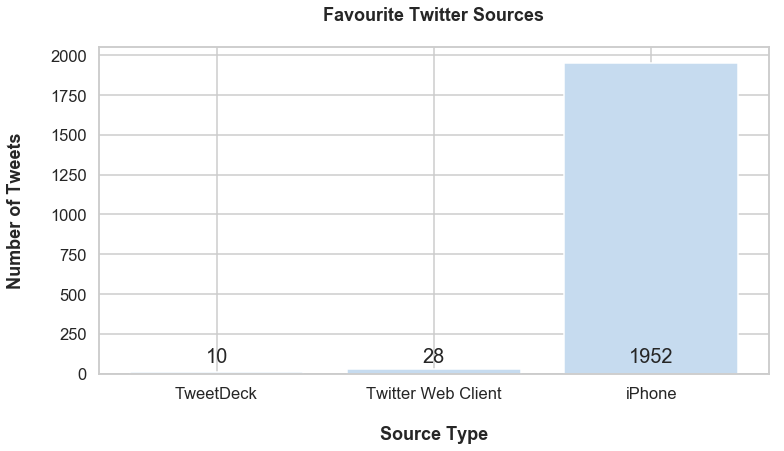

In [825]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12, 6))
axis = plt.bar(bars, fav_devices, tick_label=fav_devices.keys())
plt.title('Favourite Twitter Sources\n', fontsize=18, weight='bold')
plt.xlabel('\nSource Type', weight='bold')
plt.ylabel('Number of Tweets\n', weight='bold');
autolabel(axis, ax)
plt.savefig('favorite-sources.png')

In [826]:
fav_devices_pct = fav_devices.reset_index()
fav_devices_pct['pct'] = 100 * fav_devices_pct['tweet_id']  / fav_devices_pct['tweet_id'].sum()

In [827]:
fav_devices_pct

,source,tweet_id,pct
0,TweetDeck,10,0.502513
1,Twitter Web Client,28,1.407035
2,iPhone,1952,98.090452


Iphone is extraordinary high,pretty much excactly 98%. With a hypothetis test we could look if that is also true for the entire poulation of "we rate dog" user. A defention would look like that:

* The Null Hypothetis ($H_{0}$) states that the proportion of iPhone sources is <= the proportion of all other sources 

* The Alternative Hypothetis ($H_{1}$) states that the proportion of iPhone sources is > the proportion of all other sources 

Mathematical Hypothethis Declaration:

**$H_{0}$ : $p_{Iphone}$ <= $p_{all  other}$    
  $H_{1}$ : $p_{Iphone}$  > $p_{all  other}$**


### Retweet vs.  Favourites

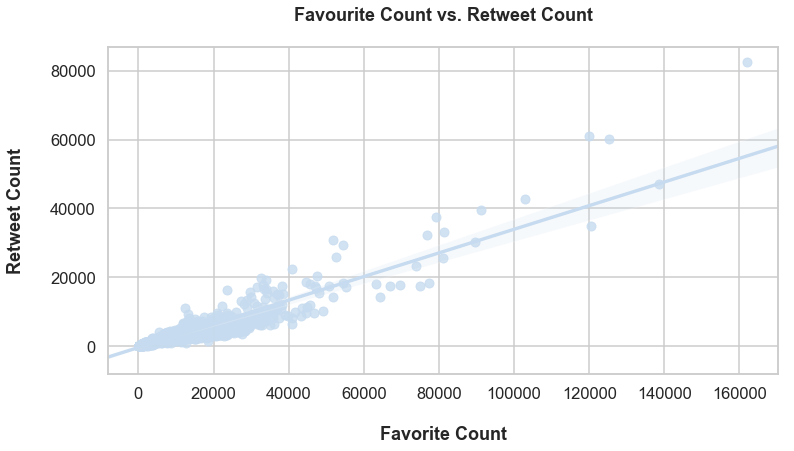

In [828]:
# scatter of favorite vs retweet count
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot( x="favorite_count", y="retweet_count", data=df, ax=ax)           
plt.title('Favourite Count vs. Retweet Count\n', fontsize=18, weight='bold')
plt.xlabel('\nFavorite Count', weight='bold')
plt.ylabel('Retweet Count\n', weight='bold');
plt.savefig('retweet-vs-favourite.png')


## Tweets over time 


In [829]:
df_ss = df.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month])['favorite_count'].sum()
df_fs 

timestamp  timestamp
2015       11            362285
           12           1234191
2016       1             645528
           2             460534
           3             523695
           4             244273
           5             337023
           6             821938
           7             588765
           8             582328
           9             680143
           10            817792
           11            740291
           12            861185
2017       1            1247900
           2            1145674
           3             891269
           4             908664
           5            1226284
           6            1197497
           7            1514476
           8              69810
Name: favorite_count, dtype: int64

In [830]:
df_time = df.copy()
df_time['month_year'] = pd.to_datetime(df_time['timestamp']).dt.to_period('M')

In [831]:
df_ts = df_time.groupby('month_year', as_index=False)['tweet_id'].count()
df_ts

,month_year,tweet_id
0,2015-11,296
1,2015-12,366
2,2016-01,169
3,2016-02,111
4,2016-03,120
5,2016-04,54
6,2016-05,57
7,2016-06,81
8,2016-07,87
9,2016-08,59


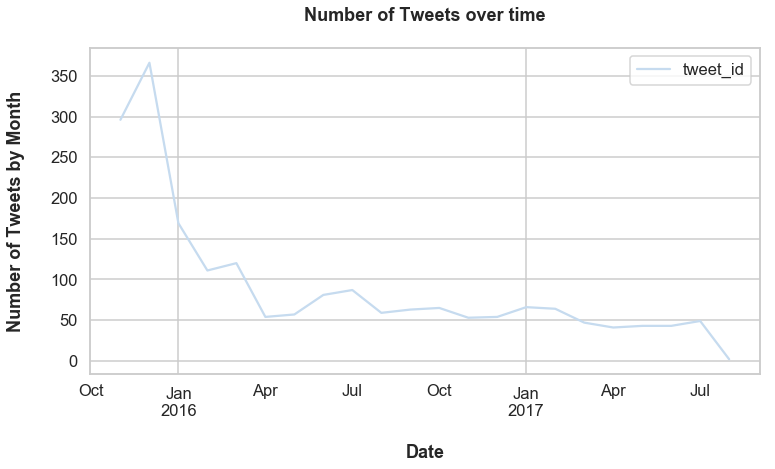

In [832]:
axs = df_ts.plot(x='month_year',figsize=(12, 6));
plt.title('Number of Tweets over time\n', fontsize=18, weight='bold')
plt.xlabel('\nDate', weight='bold')
plt.ylabel('Number of Tweets by Month\n', weight='bold');
plt.savefig('Number-of-tweets-over-time.png')